In [1]:
! pip install torch==2.5.1 torchaudio==2.5.1 torchvision==0.20.1 triton==3.1.0
! pip install open_clip_torch==2.30.0
! pip install transformers==4.47.0 bitsandbytes==0.45.0

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchaudio-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manyli

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from PIL import Image

import torch
from torchvision import transforms

# OpenCLIP
import open_clip
from open_clip import tokenizer

# 事前学習済みモデルを確認
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [3]:
# GPUかCPUかを変数へ
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# モデルの読み込み（初回はダウンロード）
model, _, transform = open_clip.create_model_and_transforms(
  'coca_ViT-L-14', pretrained='mscoco_finetuned_laion2B-s13B-b90k',
  device=device)
model.eval() # 推論モードへ

print('### Model parameters:', f'{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}')
print('### transform:\n', transform) # 前処理

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

### Model parameters: 638,450,177
### transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7eb0e349f420>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


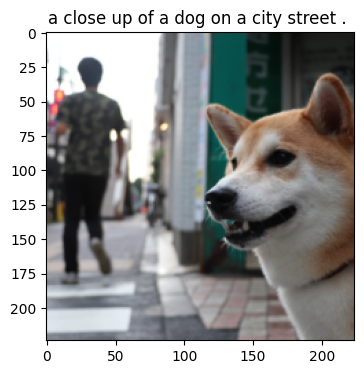

In [4]:
def generate_text_coca(img):
  image_input = transform(img).unsqueeze(0).to(device)
  with torch.no_grad(), torch.amp.autocast(device):
    generated_tokens = model.generate(image_input, seq_len=20)
  generated = open_clip.decode(generated_tokens[0].detach())
  caption = generated.split('<end_of_text>')[0].replace('<start_of_text>', '')
  return caption

# 可視化用にリサイズと切り出し処理を定義
trans = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224)
])

image_path = 'dog.jpg' # 入力画像のファイル名を記述
plt.figure(figsize=(4, 4))
img = Image.open(image_path) # 画像を読み込み
plt.imshow(trans(img))
plt.title(generate_text_coca(img)) # 生成実行
plt.show()

In [5]:
from transformers import pipeline
from transformers import BitsAndBytesConfig

model_id = 'llava-hf/llava-v1.6-mistral-7b-hf'
quantization_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_compute_dtype=torch.float16)
pipe = pipeline('image-text-to-text', model=model_id,
  model_kwargs={'quantization_config': quantization_config,
                 'low_cpu_mem_usage': True})

def generate_text_llava(img):
  prompt = '[INST] <image>\nWhat is shown in this image? [/INST]'
  generated = pipe(images=img, text=prompt,
    generate_kwargs={'max_new_tokens': 200})[0]['generated_text']
  caption = generated.split('[/INST]')[1].strip()
  return caption

print(f'\n[{generate_text_llava(img)}]') # 画像が変数imgに読み込み済みと仮定

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Device set to use cuda:0
The input data was not formatted as a chat with dicts containing 'role' and 'content' keys, even though this model supports chat. Consider using the chat format for better results. For more information, see https://huggingface.co/docs/transformers/en/chat_templating
Keyword argument `legacy` is not a valid argument for this processor and will be ignored.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.



[The image shows a Shiba Inu dog sitting on a sidewalk, looking directly at the camera. In the background, there is a person walking away from the camera, and the setting appears to be an urban street with buildings and a pedestrian crossing. The dog's expression is quite attentive and curious.]
